In [79]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np

from toolbar.wavelet import *
from toolbar.specx_anal import *

# 加载数据
data = xr.open_dataset(r"D:\PyFile\p2\data\Time_type_95%_0.1_2.nc").sel(type=1)['K'].data
#data = data - np.polyval(np.polyfit(range(len(data)), data, 1), range(len(data)))

D:\Code\work\Meteorological\toolbar\specx_anal.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  Tl[i]=2*m/l[i]
D:\Code\work\Meteorological\toolbar\specx_anal.py:66: RuntimeWarning: divide by zero encountered in divide
  return 2*m/l, Sl, Sr, Sw, r1
C:\Users\86136\AppData\Local\Temp\ipykernel_3860\2617785335.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--r" (-> color='r'). The keyword argument will take precedence.
  ax.plot(l,Sr[1],'--r',color='gray',label='red noise')


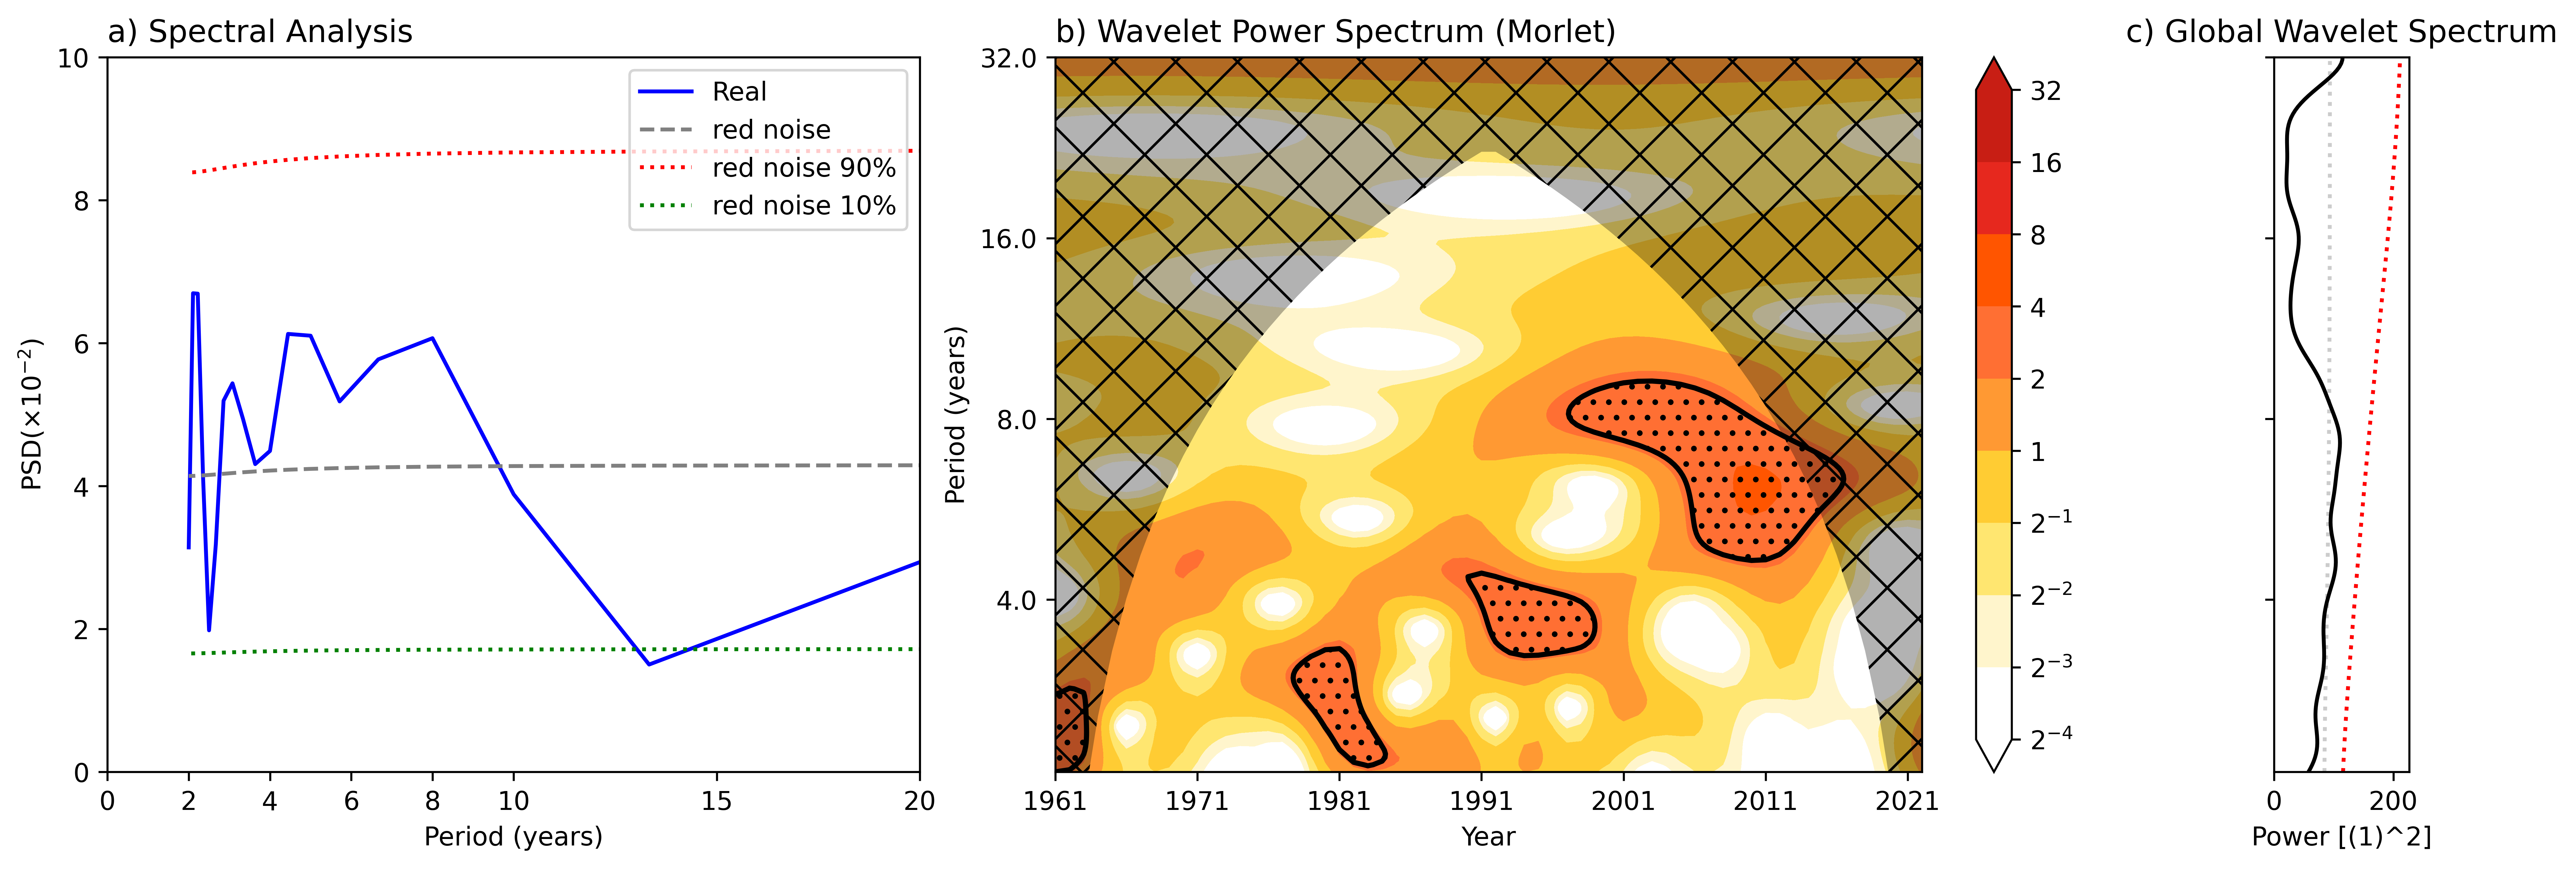

In [80]:
fig = plt.figure(figsize=(16, 5), dpi=600)
spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[3, 4, .5])
# 第一个子图，功率谱分析
l,Sl,Sr,Sw,r1 = specx_anal(data, data.shape[0]//3,0.1,0.1)
ax = fig.add_subplot(spec[0])
ax.plot(l,Sl,'-b',label='Real')
ax.plot(l,Sr[1],'--r',color='gray',label='red noise')
ax.plot(l,Sr[0],':r',label='red noise 90%')
ax.plot(l,Sr[2],':',color='green',label='red noise 10%')
ax.legend()
ax.set_xlim([0, 20])
ax.set_xticks([0, 2, 4, 6, 8, 10, 15, 20])
ax.set_xlabel('Period (years)')
ax.set_yticks(np.array([0, 2, 4, 6, 8, 10])*1e-2)
ax.set_yticklabels(np.array([0, 2, 4, 6, 8, 10]))
ax.set_ylabel('PSD(×$10^{-2}$)')
ax.set_title('a) Spectral Analysis', loc='left')

# 第二个子图，归一化小波功率谱和显著性水平等值线和虚部阴影区域。请注意，周期刻度是对数的。
# 小波分析
wavelet_analysis = WaveletAnalysis(data, wave='Morlet', dt=1, detrend=False, normal=True, signal=.90, J=7)
t = np.arange(0, data.size) * wavelet_analysis.dt
period, power, dt, mother, iwave, sig, coi, glbl_power, glbl_signif, fft_power, fft_freqs, fft_theor = wavelet_analysis.wavelet_analysis()

bx = fig.add_subplot(spec[1])
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
bx_fill = bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
                      extend='both', cmap=cmaps.sunshine_9lev)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, np.log2(period), sig, [1, 99], colors='k', linewidths=2, extent=extent)
bx.contourf(t, np.log2(period), sig, [1, 99], colors='none', hatches=['..'], extent='both')
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                        t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                        np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) Wavelet Power Spectrum ({})'.format(mother.name), loc='left')
bx.set_xticks([0, 10, 20, 30, 40, 50, 60])
bx.set_xticklabels(np.array([0, 10, 20, 30, 40, 50, 60]) + 1961)
bx.set_xlabel('Year')
bx.set_ylabel('Period (years)')
#
try:
    Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                            np.ceil(np.log2(period.max())))
except ValueError:
    Yticks = 2 ** np.arange(0, np.ceil(np.log2(period.max())))
bx.set_xlim([t.min(), t.max()])
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
bx_colorbar = plt.colorbar(bx_fill, ax=bx, orientation='vertical')
bx_colorbar.set_ticks(np.log2(levels))
bx_colorbar.set_ticklabels(['$2^{-4}$', '$2^{-3}$', '$2^{-2}$', '$2^{-1}$', '1', '2', '4', '8', '16', '32'])
try:
    bx.set_ylim([np.log2(period.min()), np.log2(2 ** int(np.log2(coi.max()))) + 1])
except ValueError:
    bx.set_ylim([np.log2(0), np.log2(2 ** int(np.log2(coi.max()))) + 1])

# 第三个子图，全局小波和傅里叶功率谱以及理论噪声谱。请注意，周期刻度是对数的。
var = wavelet_analysis.var
cx = fig.add_subplot(spec[2], sharey=bx)
#cx.plot(var * fft_power, np.log2(1. / fft_freqs), '-', color='#cccccc', linewidth=1)
cx.plot(var * fft_theor, np.log2(period), ':', color='#cccccc')
cx.plot(var * glbl_power, np.log2(period), '-', color='k', linewidth=1.5)
cx.plot(glbl_signif, np.log2(period), ':', color='red', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format('1'))
cx.set_xlim([0, np.nanmax([glbl_signif * 1.05, glbl_power * 1.05])])
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
try:
    cx.set_ylim([np.log2(period.min()), np.log2(2**int(np.log2(coi.max())))+1])
except ValueError:
    cx.set_ylim([np.log2(0), np.log2(2 ** int(np.log2(coi.max()))) + 1])

plt.show()